In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit
from qiskit import IBMQ, Aer,QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, assemble
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)
# Import IonQ basis gates
from qiskit_ionq import GPIGate, GPI2Gate, MSGate

from qiskit_experiments.library import StateTomography

In [2]:
noisemodel = NoiseModel()
prob_1q = 1-0.9986
prob_2q = 1-0.9826
time_t1 = 10000*1e9
time_t2 = 0.2*1e9
time_1q = 0.00001*1e9
time_2q = 0.0002*1e9
time_measure = 0.00013*1e9
time_reset = 0.00002*1e9

error_reset = thermal_relaxation_error(time_t1, time_t2, time_reset)
error_meas = thermal_relaxation_error(time_t1, time_t2, time_measure)
error_1q  = thermal_relaxation_error(time_t1, time_t2, time_1q)
error_2q = thermal_relaxation_error(time_t1, time_t2, time_2q).expand(
             thermal_relaxation_error(time_t1, time_t2, time_2q))
error_1 = depolarizing_error(prob_1q, 1)
error_2 = depolarizing_error(prob_2q, 2)
noisemodel.add_all_qubit_quantum_error(error_reset, "reset")
noisemodel.add_all_qubit_quantum_error(error_meas, "measure")
noisemodel.add_all_qubit_quantum_error(error_1q, ['h','rz'])
noisemodel.add_all_qubit_quantum_error(error_2q, ['cx'])
noisemodel.add_all_qubit_quantum_error(error_1, ['h', 'rz'])
noisemodel.add_all_qubit_quantum_error(error_2, ['cx'])

# Error probabilities
#prob_1 = 0.001  # 1-qubit gate
#prob_2 = 0.01   # 2-qubit gate

# Depolarizing quantum errors


# Add errors to noise model
#noise_model = noise.NoiseModel()


In [3]:
# Get basis gates from noise model
basis_gates = noisemodel.basis_gates
print(noisemodel)

NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'reset', 'h', 'measure', 'rz']
  All-qubits errors: ['reset', 'measure', 'h', 'rz', 'cx']


In [4]:
def zz_pump(q, c, p, system, ancilla, ini):
    z = QuantumCircuit(q, c)
    if ini == "01":
        z.x(q[system[0]])
    elif ini == "10":
        z.x(q[system[1]])
    elif ini == "11":
        z.x(q[system[0]])
        z.x(q[system[1]])
    
    z.cx(q[system[0]], q[system[1]])
    z.x(q[ancilla])
    z.cx(q[system[1]], q[ancilla])
    
    theta = 2 * np.arcsin(np.sqrt(p))
    
    z.cu3(theta, 0.0, 0.0, q[ancilla], q[system[1]])
    
    z.cx(q[system[1]], q[ancilla])
    # z.cx(q[system[0]], q[system[1]])
    z.h(q[system[0]])
    z.measure(q[system[0]], c[0])
    z.measure(q[system[1]], c[1])
    return z  

In [5]:
def zz_xx_pump(q, c, p, system, ancillae, ini):
    zx = QuantumCircuit(q, c)
    if ini == "01":
        zx.x(q[system[0]])
    elif ini == "10":
        zx.x(q[system[1]])
    elif ini == "11":
        zx.x(q[system[0]])
        zx.x(q[system[1]])
        
    zx.cx(q[system[0]], q[system[1]])
    zx.x(q[ancillae[0]])
    zx.cx(q[system[1]], q[ancillae[0]])
    
    theta = 2 * np.arcsin(np.sqrt(p))
    zx.cu3(theta, 0.0, 0.0, q[ancillae[0]], q[system[1]])
    
    zx.cx(q[system[1]], q[ancillae[0]])
    
    zx.h(q[system[0]])
    zx.x(q[ancillae[1]])
    zx.cx(q[system[0]], q[ancillae[1]])
    
    zx.cu3(theta, 0.0, 0.0, q[ancillae[1]], q[system[0]])
    
    zx.cx(q[system[0]], q[ancillae[1]])
    
    zx.measure(q[system[0]], c[0])
    zx.measure(q[system[1]], c[1])
    
    return zx

/tmp/ipykernel_4016/1980452409.py:16: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).
  zx.cu3(theta, 0.0, 0.0, q[ancillae[0]], q[system[1]])
/tmp/ipykernel_4016/1980452409.py:24: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).
  zx.cu3(theta, 0.0, 0.0, q[ancillae[1]], q[system[0]])


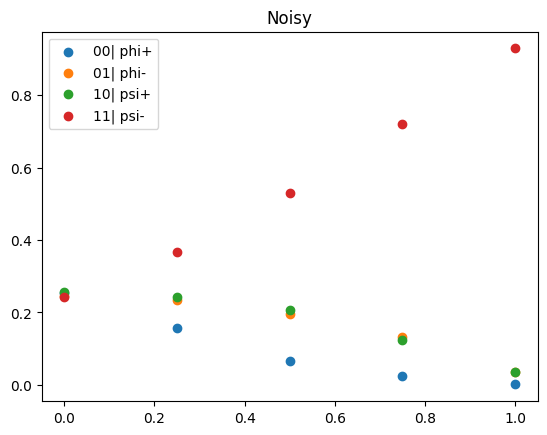

In [6]:
# use local simulator

shots = 64
p = np.linspace(0,1.0,5)
dict = {}
a = [[0] * 4 for i in range(len(p))]
b = [[0] * len(p) for i in range(4)]


labels = ['00', '01', '10', '11']
for inis in labels:
    k=0
    for i in p:
        q = QuantumRegister(5, name='q')
        c = ClassicalRegister(2, name='c')
        circ = zz_xx_pump(q, c,i, [2,1], [0,4], inis)
        sim_noise = AerSimulator(noise_model=noisemodel)
        tbell_circ_noise = transpile(circ, sim_noise)
        results = sim_noise.run(tbell_circ_noise).result()
        answer = {'00':0,'01':0,'10':0,'11':0}
        labels = list(answer.keys())
        for key,value in results.get_counts().items():
            answer[key] = value
        for j in range(4):
            a[k][j] = answer[labels[j]]/1024
        k=k+1
    # Plotting
    for l in range(4):
        for m in range(5):
            b[l][m] = b[l][m]+a[m][l]
    # print(b)

plt.title('Noisy')
plt.scatter(p,(np.asarray(b[0]))/4, label="00| phi+")
plt.scatter(p,(np.asarray(b[1]))/4,  label="01| phi-")
plt.scatter(p,(np.asarray(b[2]))/4,  label="10| psi+")
plt.scatter(p,(np.asarray(b[3]))/4,  label="11| psi-")
plt.legend()

#circ.draw(output="mpl")

In [7]:
def corr(q, c, system, ancillae, g, t, i):
    coA = QuantumCircuit(q,c)
    
    # State Preparation
    coA.h(q[system])
    coA.h(q[ancillae[2]])
    coA.cnot(q[ancillae[2]],q[ancillae[1]])
    coA.cnot(q[ancillae[2]],q[ancillae[0]])
    
    # Collisions between the system and ancilla qubits
    for j in range(1, i+1, 1):
        if j%2 != 0:
            coA.cnot(q[ancillae[0]],q[system])
            coA.rz(t, q[system])
            coA.cnot(q[ancillae[0]],q[system])
        else:
            coA.cnot(q[ancillae[1]],q[system])
            coA.rz(t, q[system])
            coA.cnot(q[ancillae[1]],q[system])
    
    coA.h(q[system])
    
    coA.measure(q[system],c[0])
        
    return coA

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


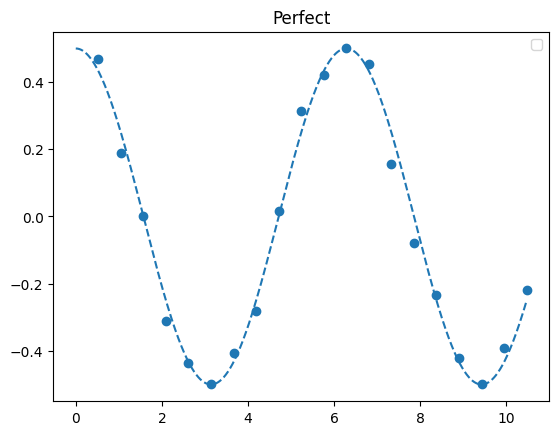

In [8]:
q = QuantumRegister(4,name = 'q')
c = ClassicalRegister(1, name = 'c')
system = 0
ancillae = [1, 2, 3]
rho_12, T = [], []
n = 20
tt = np.pi/6
g = 1
t = g*(tt)
for i in range(1,n+1,1):
    circ = corr(q, c, system, ancillae, g, tt, i)
    if i == 3:
        qq = circ
    T.append(i*t)
    job = qiskit.execute(circ, Aer.get_backend('qasm_simulator'), shots=64)
    counts = job.result().get_counts()
    rho_12.append((counts.get('0',0)-counts.get('1',0))/(2*(counts.get('0',0)+counts.get('1',0))))
    
plt.scatter(T, np.real(rho_12))
#qq.draw(output="mpl")
def corrfunc(time):
    return (np.cos(time/2)**2-np.sin(time/2)**2)/2

x_ax = np.linspace(0,T[-1],num=1000)
plt.title('Perfect')
plt.plot(x_ax,corrfunc(x_ax),linestyle='--')
plt.legend()
plt.show()

In [12]:
q = QuantumRegister(4,name = 'q')
c = ClassicalRegister(1, name = 'c')
system = 0
ancillae = [1, 2, 3]
rho_12, T = [], []
n = 40
tt = np.pi/6
g = 1
t = g*(tt)
numcx = []
gatedepth = []
fidy = []
for i in range(1,n+1,1):
    circ = corr(q, c, system, ancillae, g, tt, i)
    if i == 3:
        qq = circ
    #print(f'Count op for {i} collisions: {circ.depth()}')
    numcx.append(circ.count_ops()['cx'])
    gatedepth.append(circ.depth())
    T.append(i*t)
    job = qiskit.execute(circ, Aer.get_backend('qasm_simulator'),basis_gates=basis_gates,noise_model=noisemodel, shots=256)
    counts = job.result().get_counts()
    ideal_unitary = outer(ideal_unitary.ravel(order='F'))
    pt_circs = process_tomography_circuits(circ, q)
    job2 = qiskit.execute(qpt_circs, Aer.get_backend('qasm_simulator'), shots=4000)
    qpt_tomo = ProcessTomographyFitter(job2.result(), qpt_circs)
    qpt_tomo.data

    choi_lstsq = qpt_tomo.fit(method='lstsq')
    print('fit fidelity (process):', np.real(process_fidelity(choi_ideal, choi_lstsq.data, require_cptp=False)))
    
    rho_12.append((counts.get('0',0)-counts.get('1',0))/(2*(counts.get('0',0)+counts.get('1',0))))
    fidy.append(np.real(process_fidelity(choi_ideal, choi_lstsq.data, require_cptp=False)))
plt.scatter(T, np.real(rho_12))
#qq.draw(output="mpl")
def corrfunc(time):
    return (np.cos(time/2)**2-np.sin(time/2)**2)/2

abserr = [abs(rho_12[i]-corrfunc(T[i])) for i in range(len(numcx))]

x_ax = np.linspace(0,T[-1],num=1000)
plt.title('Noisy')
plt.plot(x_ax,corrfunc(x_ax),linestyle='--')
plt.legend()
plt.show()

NameError: name 'outer' is not defined

In [11]:
# Run circuit on unitary simulator to find ideal unitary
job = qiskit.execute(circ, Aer.get_backend('unitary_simulator'))
ideal_unitary = job.result().get_unitary(circ)
# convert to Choi-matrix in column-major convention
choi_ideal = outer(ideal_unitary.ravel(order='F'))

# Generate process tomography circuits and run on qasm simulator
qpt_circs = process_tomography_circuits(circ, q)
job = qiskit.execute(qpt_circs, Aer.get_backend('qasm_simulator'), shots=4000)

# Extract tomography data so that counts are indexed by measurement configuration
qpt_tomo = ProcessTomographyFitter(job.result(), qpt_circs)
qpt_tomo.data

choi_lstsq = qpt_tomo.fit(method='lstsq')
print('fit fidelity (process):', np.real(process_fidelity(choi_ideal, choi_lstsq.data, require_cptp=False)))

Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Circuit circuit-4318 contains invalid instructions {"instructions": {save_unitary}} for "statevector" method.


QiskitError: 'Data for experiment "circuit-4318" could not be found.'

In [ ]:
plt.plot(numcx,abserr,c='red')
plt.scatter(numcx,abserr)
plt.xlabel('Number of CNOT gates')
plt.ylabel('Absolute error')
plt.show()

In [ ]:
plt.plot(numcx,gatedepth,c='red')
plt.scatter(numcx,gatedepth)
plt.xlabel('Number of CNOT gates')
plt.ylabel('Absolute error')
plt.show()

In [ ]:
def uncorr(q, c, system, ancillae, g, t, i):
    ucoA = QuantumCircuit(q,c)
    ucoA.h(q[system])
    # State Preparation
    for l in range(i):
        ucoA.h(q[ancillae[l]])
    
    # Collisions between the system and ancilla qubits
    for j in range(1,i+1):
        ucoA.cnot(q[j],q[system])
        ucoA.rz(t, q[system])
        ucoA.cnot(q[j],q[system])
    
    ucoA.h(q[system])
    
    ucoA.measure(q[system],c[0])
        
    return ucoA

In [ ]:
n = 7
q = QuantumRegister(n+1,name = 'q')
c = ClassicalRegister(1, name = 'c')
system = 0
ancillae = range(1,n+1)
rho_12, T = [], []
tt = np.pi/6
g = 1
t = g*(tt)
for i in range(1,n+1,1):
    circ = uncorr(q, c, system, ancillae, g, 2*tt, i)
    if i == 4:
        qq = circ
    T.append(i*t)
    job = qiskit.execute(circ, Aer.get_backend('qasm_simulator'), shots=1024)
    counts = job.result().get_counts()
    rho_12.append((counts.get('0',0)-counts.get('1',0))/(2*(counts.get('0',0)+counts.get('1',0))))

def uncorrfunc(i):
    return np.power(np.cos(2*g*tt),i/t)/2

x_ax = np.linspace(0,T[-1],num=1000)
plt.title('Perfect')
plt.plot(x_ax,uncorrfunc(x_ax),linestyle='--')
plt.scatter(T, rho_12)

In [ ]:
n = 20
q = QuantumRegister(n+1,name = 'q')
c = ClassicalRegister(1, name = 'c')
system = 0
ancillae = range(1,n+1)
rho_12, T = [], []
tt = np.pi/6
g = 1
t = g*(tt)
for i in range(1,n+1,1):
    circ = uncorr(q, c, system, ancillae, g, 2*tt, i)
    if i == 4:
        qq = circ
    T.append(i*t)
    job = qiskit.execute(circ, Aer.get_backend('qasm_simulator'),basis_gates=basis_gates,noise_model=noisemodel, shots=256)
    counts = job.result().get_counts()
    rho_12.append((counts.get('0',0)-counts.get('1',0))/(2*(counts.get('0',0)+counts.get('1',0))))

def uncorrfunc(i):
    return np.power(np.cos(2*g*tt),i/t)/2

x_ax = np.linspace(0,T[-1],num=1000)
plt.title('Noisy')
plt.plot(x_ax,uncorrfunc(x_ax),linestyle='--')
plt.scatter(T, rho_12)

In [ ]:
def depolarizing_channel(q, p, system, ancillae):
    """Returns a QuantumCircuit implementing depolarizing channel on q[system]
    
    Args:
        q (QuantumRegister): the register to use for the circuit
        p (float): the probability for the channel between 0 and 1
        system (int): index of the system qubit
        ancillae (list): list of indices for the ancillary qubits
        
    Returns:
        A QuantumCircuit object
    """
    z = QuantumCircuit(q)
    
    theta = 0.5*np.arccos(1-(2*p))
    
    t1 = np.pi/4
    t2 = np.pi/4
    
    z.ry(theta, q[ancillae[0]])
    z.ry(theta, q[ancillae[1]])
    z.ry(theta, q[ancillae[2]])
    
    z.ry(t1, q[system])
    z.rz(t2, q[system])
    
    z.cx(q[ancillae[0]], q[system])
    z.cy(q[ancillae[1]], q[system])
    z.cz(q[ancillae[2]], q[system])
    
    return z

In [ ]:
p = np.linspace(0,1.0,10)
q = QuantumRegister(5,name = 'q')
system = 2
ancillae = [1,3,4]
rho11, rho22, Rrho12, Irho12 = [], [], [], []
for i in p:
    circuit = depolarizing_channel(q, i, system, ancillae)
    qst_bell = state_tomography_circuits(circuit, q[system])
    job = qiskit.execute(qst_bell, Aer.get_backend('qasm_simulator'), shots=5000)
    tomo_fitter_bell = StateTomographyFitter(job.result(), qst_bell)
    rho = tomo_fitter_bell.fit(method='lstsq')
    rho11.append(rho[0,0])
    rho22.append(rho[1,1])
    Rrho12.append(np.real(rho[0,1]))
    Irho12.append(np.imag(rho[0,1]))

plt.scatter(p, rho11, label="rho11")
plt.scatter(p, rho22, label="rho22")
plt.scatter(p, Rrho12, label="Rrho12")
plt.scatter(p, Irho12, label="Irho12")
plt.legend()
plt.show()